<a href="https://colab.research.google.com/github/shireesha-palakurla/CODSOFT/blob/main/Titanic_Survival__Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
import matplotlib
%matplotlib inline

### Loading data

In [2]:
df = pd.read_csv('/content/Titanic-Dataset.csv')

### Exploration

In [3]:
# SibSp: number of siblings and spouses traveling with
# Parch: number of parents and children traveling with
# The embarkation : It has three possible values S,C,Q
df['Age'].fillna(df['Age'].median(), inplace=True)
df.describe()

/tmp/ipython-input-2897855132.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Text(0.5, 1.0, 'Women and children first !')

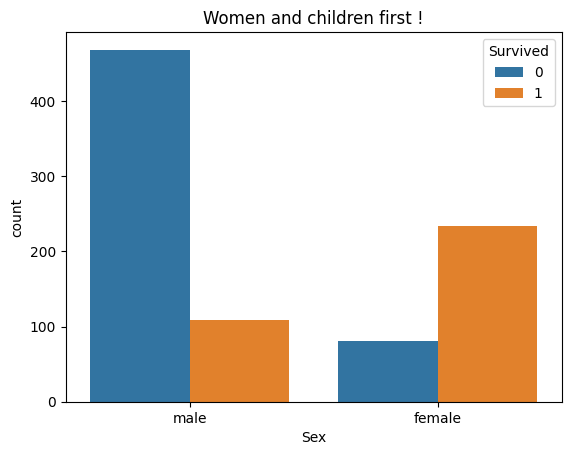

In [4]:
sns.countplot(x= 'Sex', hue='Survived', data=df)
plt.title("Women and children first !")

Text(0.5, 1.0, 'Women and children first !')

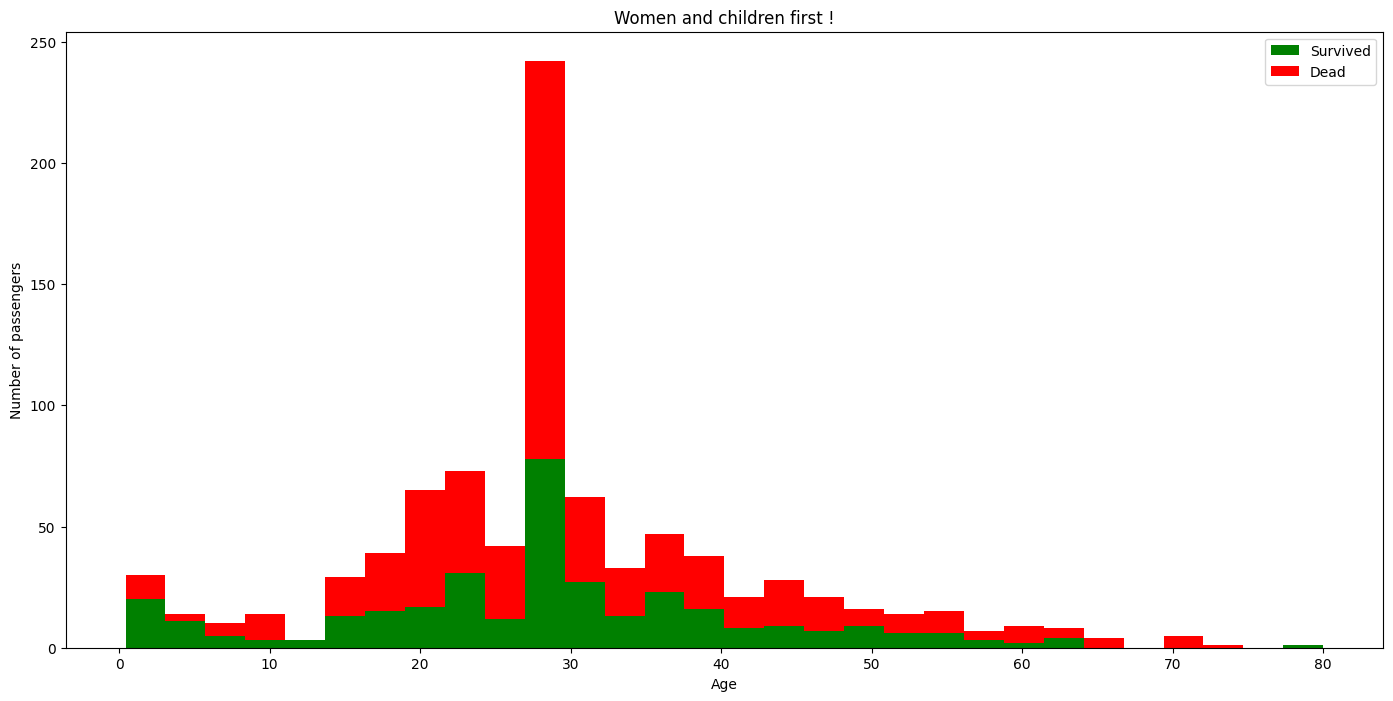

In [5]:
figure = plt.figure(figsize=(17,8))
plt.hist([df[df['Survived']==1]['Age'], df[df['Survived']==0]['Age']], stacked=True, color = ['g','r'],
         bins = 30, label = ['Survived','Dead'])
plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.legend()
plt.title("Women and children first !")

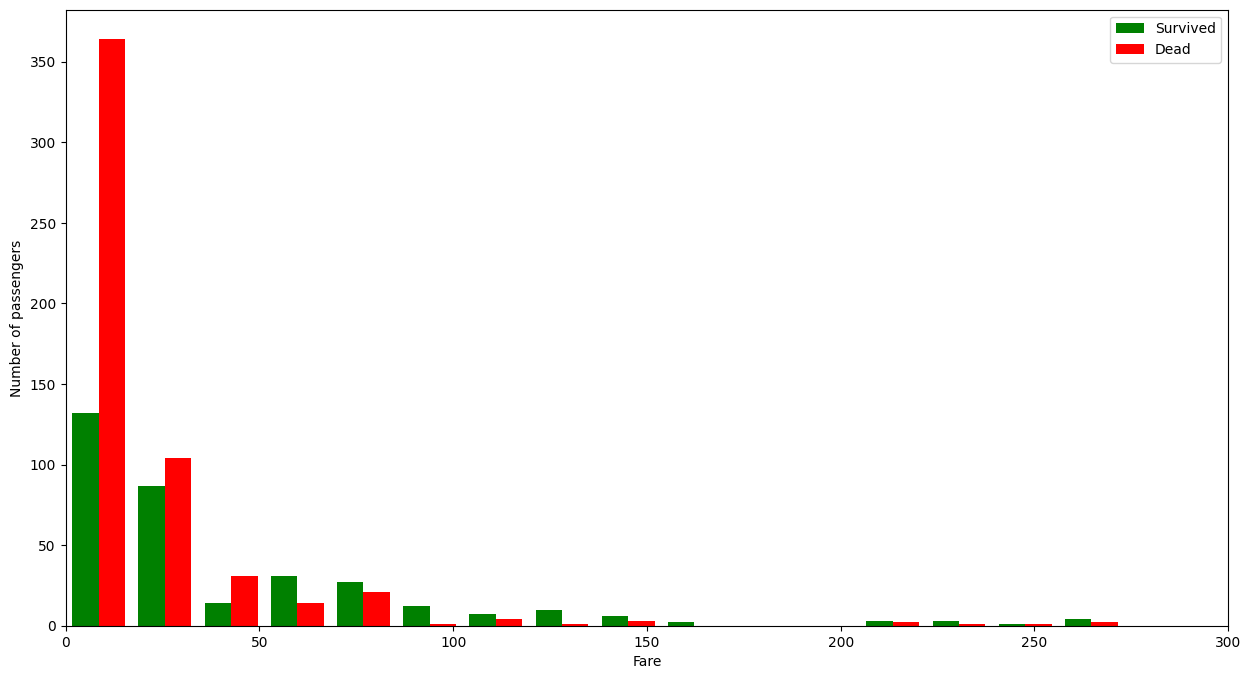

In [6]:
figure = plt.figure(figsize=(15,8))
plt.hist([df[df['Survived']==1]['Fare'],
          df[df['Survived']==0]['Fare']], color = ['g','r'],
         bins = 30,label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.xlim([0,300])
plt.ylabel('Number of passengers')
plt.legend()

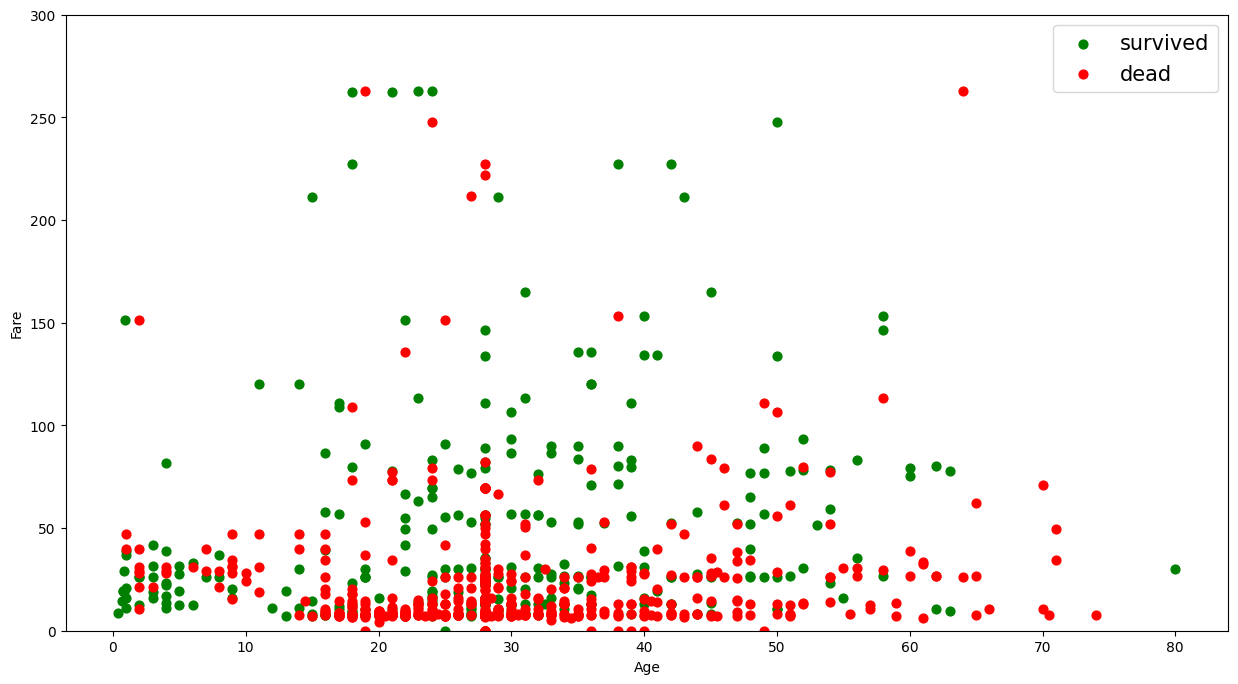

In [7]:
plt.figure(figsize=(15,8))
ax = plt.subplot()
ax.scatter(df[df['Survived']==1]['Age'],df[df['Survived']==1]['Fare'], c='green',s=40)
ax.scatter(df[df['Survived']==0]['Age'],df[df['Survived']==0]['Fare'], c='red',s=40)
ax.set_xlabel('Age')
ax.set_ylabel('Fare')
ax.set_ylim([0,300])
ax.legend(('survived','dead'),scatterpoints=1,loc='upper right',fontsize=15,)

<Axes: xlabel='Embarked', ylabel='count'>

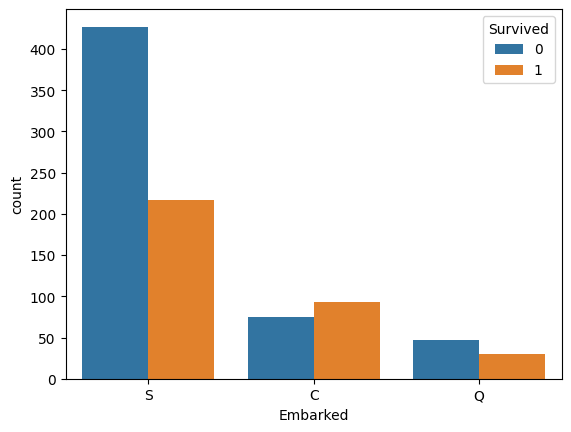

In [8]:
sns.countplot(x= 'Embarked', hue='Survived', data=df)

### Feature Engineering

In [9]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
targets = train.Survived
train.drop('Survived', axis=1, inplace=True)
combined = pd.concat([train, test], ignore_index=True)

In [10]:
# Extracting title from the names
Title_Dictionary = {"Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Lady" :      "Royalty"}
combined['Title'] = combined['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
combined['Title'] = combined.Title.apply(lambda x:Title_Dictionary.get(x,x))

In [11]:
grouped_median_train = combined.iloc[:len(train)].groupby(['Sex','Pclass','Title'])[['Age', 'SibSp', 'Parch', 'Fare']].median()
grouped_median_test = combined.iloc[len(train):].groupby(['Sex','Pclass','Title'])[['Age', 'SibSp', 'Parch', 'Fare']].median()

In [12]:
def fillAges(row, grouped_median):
    if np.isnan(row['Age']):
        return grouped_median.loc[row['Sex'], row['Pclass'], row['Title']]['Age']
    else:
        return row['Age']

In [13]:
# Fills in the missing age in combined based on these different attributes.
combined.loc[:len(train)-1, 'Age'] = combined.loc[:len(train)-1].apply(lambda r : fillAges(r, grouped_median_train), axis=1)
combined.loc[len(train):, 'Age'] = combined.loc[len(train):].apply(lambda r : fillAges(r, grouped_median_test), axis=1)

In [14]:
le_title = LabelEncoder()
combined['Title'] = le_title.fit_transform(combined['Title'])

In [15]:
# Fills the fare by the mean
combined.Fare.fillna(combined.Fare.mean(), inplace=True)

# Fills the embarked by the most common
combined.Embarked.fillna('S', inplace=True)

le_embarked = LabelEncoder()
combined['Embarked'] = le_embarked.fit_transform(combined['Embarked'])

# Replacing missing cabins with U (for Uknown)
combined.Cabin.fillna('U', inplace=True)
# mapping each Cabin value with the cabin letter
combined['Cabin'] = combined['Cabin'].map(lambda c : c[0])

le_cabin = LabelEncoder()
combined['Cabin'] = le_cabin.fit_transform(combined['Cabin'])

# Encoder for Sex
le_sex = LabelEncoder()
combined['Sex'] = le_sex.fit_transform(combined['Sex'])

/tmp/ipython-input-4244679386.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined.Fare.fillna(combined.Fare.mean(), inplace=True)
/tmp/ipython-input-4244679386.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

In [16]:
def cleanTicket(ticket):
    ticket = ticket.replace('.','')
    ticket = ticket.replace('/','')
    ticket = ticket.split()
    ticket = list(map(lambda t : t.strip(), ticket))
    ticket = list(filter(lambda t : not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else:
        return 'XXX'

In [17]:
combined['Ticket'] = combined['Ticket'].apply(cleanTicket)
le_ticket = LabelEncoder()
combined['Ticket'] = le_ticket.fit_transform(combined['Ticket'])

In [18]:
# Variables around family feature
combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1
combined['Singleton'] = combined['FamilySize'].map(lambda s: 1 if s == 1 else 0)
combined['SmallFamily'] = combined['FamilySize'].map(lambda s: 1 if 2<=s<=4 else 0)
combined['LargeFamily'] = combined['FamilySize'].map(lambda s: 1 if 5<=s else 0)

combined.drop('PassengerId', inplace=True, axis=1)

### Modeling

In [19]:
X_train = combined.head(len(train))
X_test = combined[len(train):]
y_train = df.Survived

In [20]:
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)

In [21]:
X_train = X_train.drop('Name', axis=1)
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(X_train, y_train)

In [22]:
# feat_imp = dict(zip(X_train.columns[np.argsort(clf.feature_importances_)[::-1]],
#     np.sort(clf.feature_importances_)[::-1]))
# new_cols = [k for k,v in feat_imp.items() if v > 0.02]
# train_reduced = X_train[new_cols]
# test_reduced = X_test[new_cols]

model = SelectFromModel(clf, prefit=True)
train_reduced = model.transform(X_train)
X_test = X_test.drop('Name', axis=1)
test_reduced = model.transform(X_test)
train_reduced.shape, X_train.shape

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


((891, 4), (891, 14))

In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# turn run_gs to True if you want to run the gridsearch again.
run_gs = False

if run_gs:
    parameter_grid = {
                 'max_depth' : [4, 6, 8],
                 'n_estimators': [50, 10],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [True, False],
                 }
    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(y_train, n_splits=5)

    grid_search = GridSearchCV(forest,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation)

    grid_search.fit(train_reduced, y_train)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
else:
    parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50,
                  'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
    model = RandomForestClassifier(**parameters)
    model.fit(train_reduced, y_train)

In [24]:
compute_score(model, train_reduced, y_train, scoring='accuracy')

np.float64(0.7912434875400163)

In [25]:
output = model.predict(test_reduced).astype(int)
df_output = pd.DataFrame()
aux = pd.read_csv('/content/test.csv')
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('output.csv',index=False)

In [26]:
model.score(train_reduced, y_train)

0.8496071829405163

Accuracy of the model is 84.6%